# __Interpolação: Exemplos__

In [12]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from CB2325NumericaG6.interpolacao import HermiteInterpolation, hermite_interp, PolinomialInterpolation, poly_interp, PiecewiseLinearFunction, linear_interp, plt, np

from random import randint

---

# __Exemplos: Interpolação Linear__

---

## Exemplo 1:

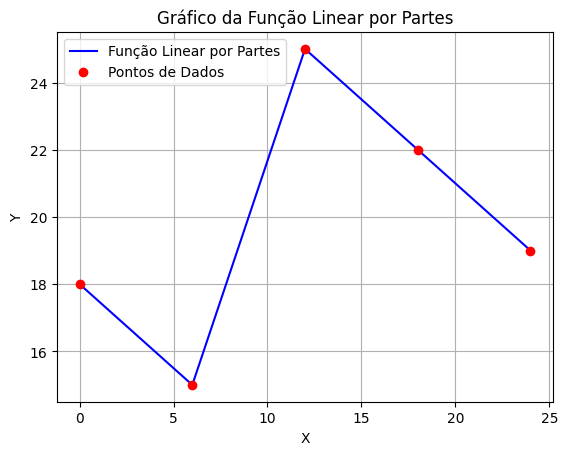

In [13]:
x = [0, 6, 12, 18, 24]
y = [18, 15, 25, 22, 19]

interpol = linear_interp(x, y)
fig, ax = interpol.plot()
plt.show()

---

## Exemplo 2:

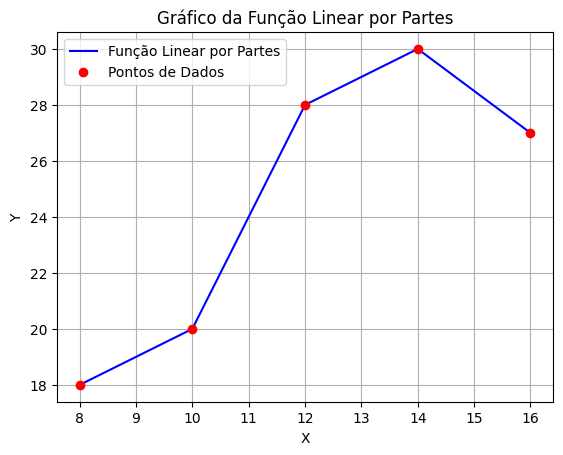

In [14]:
x = [8.0, 10.0, 12.0, 14.0, 16.0]
y = [18.0, 20.0, 28.0, 30.0, 27.0]

interpol = linear_interp(x,y)
fig, ax = interpol.plot()
plt.show()

---

## Exemplo 3: casos aleatórios

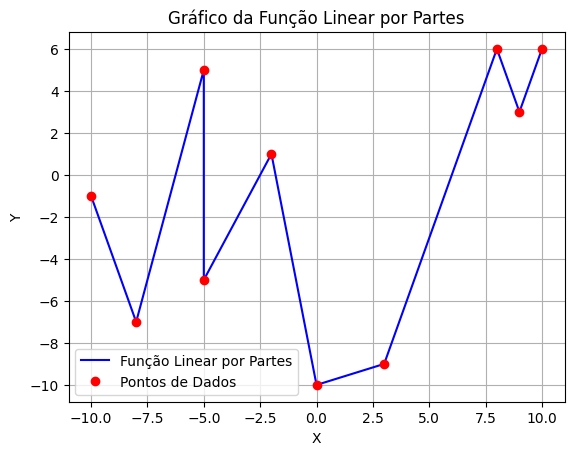

In [15]:
# Gera 10 pontos (x,y) aleatórios, com -10 < x,y < 10
x = sorted([randint(-10,10) for k in range(10)])
y = [randint(-10,10) for k in range(10)]

interpol = linear_interp(x,y)
interpol.plot()
plt.show()

---

# __Exemplos: Interpolação Polinomial__

---

## Exemplo 1:

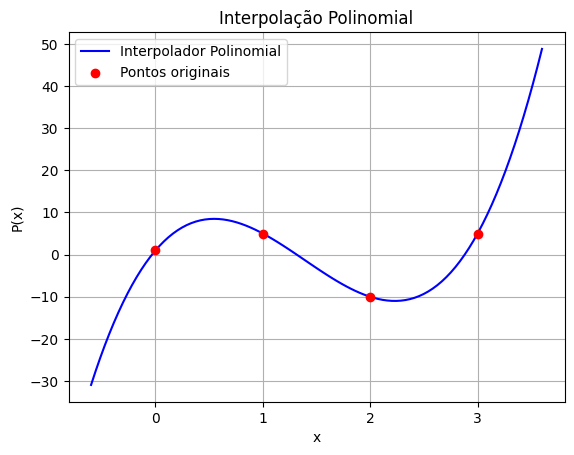

In [16]:
x_poly = [0, 1, 2, 3]
y_poly = [1, 5, -10, 5]


interpol = poly_interp(x_poly, y_poly)
fig, ax = interpol.plot()
plt.show()

---

## Exemplo 2:

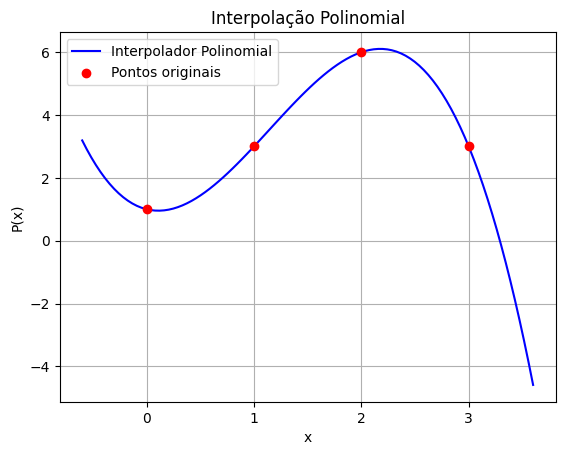

In [17]:
x_poly = [0,1,2,3]
y_poly = [1,3,6,3]

interpol = poly_interp(x_poly, y_poly)
fig, ax = interpol.plot()
plt.show()


---

## Exemplo 3: casos aleatórios

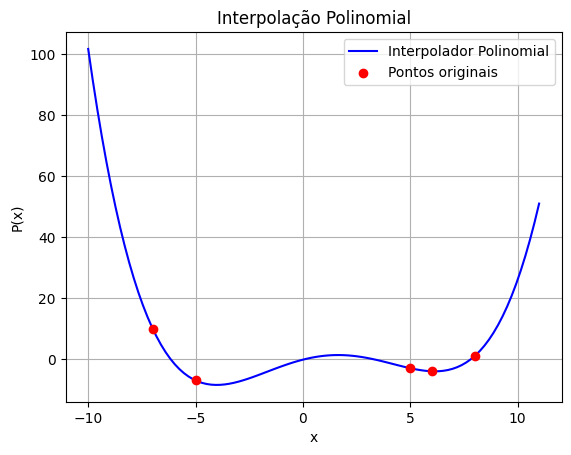

In [18]:
# Gera 5 pontos (x,y) aleatórios, com -10 < x,y < 10
x = sorted([randint(-10,10) for k in range(5)])
y = [randint(-10,10) for k in range(5)]

interpol = poly_interp(x,y)
interpol.plot()
plt.show()

---

# __Exemplos: Interpolador de Hermite__

---

## Exemplo 1:

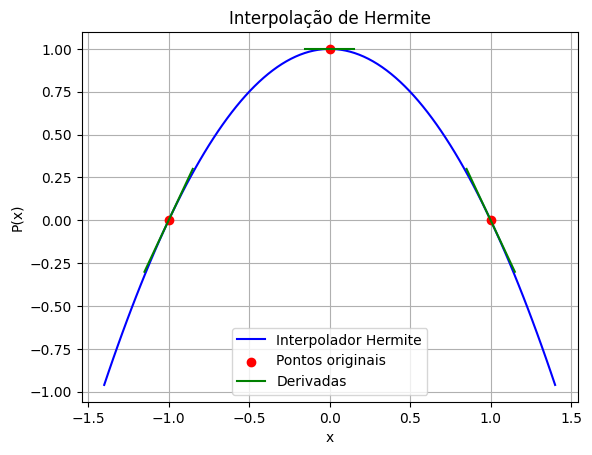

In [19]:
x = [-1, 0, 1]
y = [0, 1, 0]
dy = [-2*x_i for x_i in x]

interpol = hermite_interp(x, y, dy)
interpol.plot()
plt.show()


---

## Exemplo 2

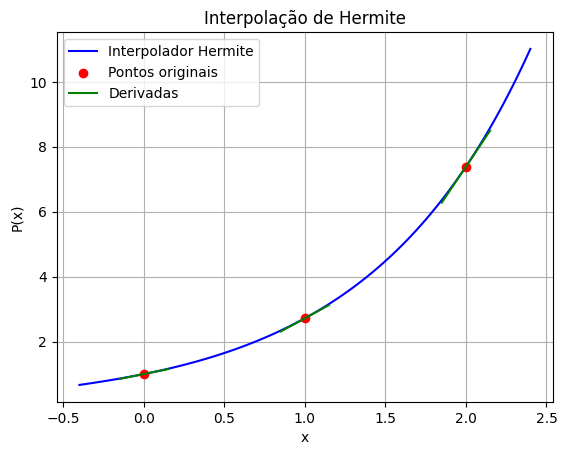

In [20]:
x = [0, 1, 2]
y = [np.exp(xi) for xi in x]
dy = [np.exp(xi) for xi in x]

interpol = hermite_interp(x, y, dy)
interpol.plot()
plt.show()

---